In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.signal import correlate
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline

In [2]:
# Function to load the CSV data
def load_results(file_path):
    return pd.read_csv(file_path)

In [3]:
# Function to plot the raw data
def plot_raw_data(df):
    # Limit the number of points plotted to avoid performance issues
    df_sampled = df.iloc[::10]  # Change the step size as needed to reduce points
    
    plt.figure(figsize=(15, 5))
    plt.plot(df_sampled.index, df_sampled['true_x'], label='True X')
    plt.plot(df_sampled.index, df_sampled['predicted_x'], label='Predicted X')
    plt.legend()
    plt.title('X Trajectory')
    plt.xlabel('Index')
    plt.ylabel('X Position')
    plt.show()

    plt.figure(figsize=(15, 5))
    plt.plot(df_sampled.index, df_sampled['true_y'], label='True Y')
    plt.plot(df_sampled.index, df_sampled['predicted_y'], label='Predicted Y')
    plt.legend()
    plt.title('Y Trajectory')
    plt.xlabel('Index')
    plt.ylabel('Y Position')
    plt.show()

# Function to calculate the length of a trajectory
def calculate_trajectory_length(df):
    distances = np.sqrt((np.diff(df['true_x'])**2) + (np.diff(df['true_y'])**2))
    total_length = np.sum(distances)
    return total_length

# Function to calculate RMSE using Euclidean distance
def calculate_rmse(df):
    distances = np.sqrt((df['true_x'] - df['predicted_x'])**2 + (df['true_y'] - df['predicted_y'])**2)
    rmse = np.sqrt(np.mean(distances**2))
    return rmse

In [4]:
# Function to apply a moving average filter to the predicted data
def moving_average(data, window_size=20000):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')



ERROR_WEIGHT = 2  # Define the error weight to be used in specified conditions

def corner_accuracy_metric(df):
    # Initialize an empty list to store adjusted errors
    adjusted_errors = []

    # Calculate errors and apply conditional weight based on ground truth position
    for index, row in df.iterrows():
        x = row['true_x']
        y = row['true_y']
        error = np.sqrt((x - row['predicted_x']) ** 2 + (y - row['predicted_y']) ** 2)

        # Define the conditions under which the error weight is applied
        if ((x < 15 and 15 <= y <= 30) or
            (x < 30 and 45 <= y <= 55) or
            (x > 25 and y < 15) or
            (x > 45 and 25 <= y <= 40)):
            error *= ERROR_WEIGHT

        # Add the possibly adjusted error to the list
        adjusted_errors.append(error)

    # Calculate the RMSE with potentially adjusted errors
    weighted_rmse = np.sqrt(np.mean(np.square(adjusted_errors)))
    return weighted_rmse

def calculate_drifting_error(df):
    # Calculate the ground truth drift using Euclidean distance
    ground_truth_start_x = df.loc[df.index[0], 'true_x']
    ground_truth_start_y = df.loc[df.index[0], 'true_y']
    ground_truth_end_x = df.loc[df.index[-1], 'true_x']
    ground_truth_end_y = df.loc[df.index[-1], 'true_y']
    ground_truth_drift = np.sqrt((ground_truth_end_x - ground_truth_start_x) ** 2 +
                                 (ground_truth_end_y - ground_truth_start_y) ** 2)

    # Calculate the prediction drift using Euclidean distance
    prediction_start_x = df.loc[df.index[0], 'predicted_x']
    prediction_start_y = df.loc[df.index[0], 'predicted_y']
    prediction_end_x = df.loc[df.index[-1], 'predicted_x']
    prediction_end_y = df.loc[df.index[-1], 'predicted_y']
    prediction_drift = np.sqrt((prediction_end_x - prediction_start_x) ** 2 +
                               (prediction_end_y - prediction_start_y) ** 2)

    # Calculate the absolute difference in drifts
    drifting_error = np.abs(ground_truth_drift - prediction_drift)
    return drifting_error

In [5]:
# Function to process the data
def process_data(df, test_type):
    # Determine the range based on test_type
    if test_type == '4-test':
        start_index = 75000
        end_index = 85000
    elif test_type in ['6-test', '7-test']:
        start_index = 500
        end_index = len(df) - 4000

    # Extract the specified range of data
    y_test = df[['true_x', 'true_y']].values[start_index:end_index]
    y_pred = df[['predicted_x', 'predicted_y']].values[start_index:end_index]

    # Apply moving average filter to each predicted dimension separately
    y_pred_filtered = np.array([moving_average(y_pred[:, i]) for i in range(y_pred.shape[1])]).T

    # Align the test data to match the length of the filtered predictions
    y_test_aligned = y_test[len(y_test) - len(y_pred_filtered):]

    # Calculate the RMSE before filtering
    #rmse_before_filter = np.sqrt(mean_squared_error(y_test_aligned, y_pred_filtered))
    #print(f'RMSE before filtering: {rmse_before_filter}')

    # Calculate scaling factors using standard deviation
    scaling_factors = np.std(y_test_aligned, axis=0) / np.std(y_pred_filtered, axis=0)

    # Apply scaling factors to the filtered predicted data
    y_pred_scaled = y_pred_filtered * scaling_factors

    # Calculate the mean of the aligned ground truth and scaled predictions
    mean_y_test = np.mean(y_test_aligned, axis=0)
    mean_y_pred = np.mean(y_pred_scaled, axis=0)

    # Calculate the shift required to align the means
    shift = mean_y_test - mean_y_pred

    # Apply the shift to the scaled predicted data
    y_pred_scaled_shifted = y_pred_scaled + shift

    # Calculate the RMSE after filtering
    #rmse_after_filter = np.sqrt(mean_squared_error(y_test_aligned, y_pred_scaled_shifted))
    #print(f'RMSE after filtering: {rmse_after_filter}')

    # Function to find the best shift using cross-correlation
    def find_best_shift(y_true, y_pred):
        correlation = correlate(y_true, y_pred)
        lag = correlation.argmax() - (len(y_pred) - 1)
        return lag

    # Apply the best shift for each dimension
    lag_x = find_best_shift(y_test_aligned[:, 0], y_pred_scaled_shifted[:, 0])
    lag_y = find_best_shift(y_test_aligned[:, 1], y_pred_scaled_shifted[:, 1])

    # Create copies of the data to apply the shifts
    y_pred_final_x = np.roll(y_pred_scaled_shifted[:, 0], shift=lag_x)
    y_pred_final_y = np.roll(y_pred_scaled_shifted[:, 1], shift=lag_y)

    # Combine the shifted dimensions back into a single array
    y_pred_final = np.column_stack((y_pred_final_x, y_pred_final_y))

    # Create a dataframe to store the results
    processed_df = pd.DataFrame({
        #'index': df.index[start_index:start_index + len(y_test_aligned)],
        #'time': df['time'].iloc[start_index:start_index + len(y_test_aligned)],
        'true_x': y_test_aligned[:, 0],
        'true_y': y_test_aligned[:, 1],
        'predicted_x': y_pred_final[:, 0],
        'predicted_y': y_pred_final[:, 1],
    })
    
    rmse = calculate_rmse(processed_df)
    print("RMSE of the filtered and scaled and shifted prediction:", rmse)
    
    return processed_df, scaling_factors, shift, (lag_x, lag_y)

In [6]:
# Function to save processed data
def save_processed_data(processed_df, model_name):
    results_dir = 'own/processed_results'
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
    
    processed_df.to_csv(f'{results_dir}/{model_name}_processed.csv', index=False)
    print(f'Processed results saved to {results_dir}/{model_name}_processed.csv')

In [7]:
def plot_processed_data_report(df, model_name):
    # Extract the required range of samples
    #plot_data = df.iloc[2900:7150]
    #plot_data = df.iloc[17000:36000]
    plot_data = df
    #plot_data = df.iloc[1000:21000]
    #plot_data = df.iloc[29500:48000]
    
    total_length = calculate_trajectory_length(plot_data)
    rmse = calculate_rmse(plot_data)
    print("Total Length of Ground Truth Trajectory single round:", total_length)
    print("RMSE of the prediction single:", rmse)
    
    weighted_rmse = corner_accuracy_metric(plot_data)
    print("Weighted RMSE (Corner Accuracy Metric):", weighted_rmse)
    
    drifting_error = calculate_drifting_error(plot_data)
    print("Drifting Error:", drifting_error)

    # Write the data to a CSV file
    output_dir = "own/results/plots"
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, f"{model_name}.csv")
    plot_data.to_csv(output_file, index=False)

    # Create a figure with GridSpec layout
    fig = plt.figure(figsize=(19.2, 10.8))
    gs = GridSpec(3, 2, figure=fig, width_ratios=[2, 1], height_ratios=[0.1, 1, 1])

    # Plot the X-Y trajectory on the left
    ax0 = fig.add_subplot(gs[1:, 0])
    ax0.scatter(plot_data['true_x'], plot_data['true_y'], label='Ground truth', color='blue', s=30)  # Increase dot size
    ax0.scatter(plot_data['predicted_x'], plot_data['predicted_y'], label='Prediction', color='red', s=30)  # Increase dot size
    ax0.legend(fontsize=20, loc='upper left')  # Move legend inside the graph
    ax0.set_xlabel('Trajectory x in m', fontsize=25, labelpad=20)  # Increase padding
    ax0.set_ylabel('Trajectory y in m', fontsize=25, labelpad=20)  # Increase padding
    ax0.axis('equal')
    ax0.tick_params(axis='both', which='major', labelsize=25, width=3)  # Increase thickness of the axis
    ax0.spines['top'].set_linewidth(3)
    ax0.spines['right'].set_linewidth(3)
    ax0.spines['bottom'].set_linewidth(3)
    ax0.spines['left'].set_linewidth(3)
    # Remove grid lines
    ax0.grid(False)

    # Plot the X trajectory over time
    ax1 = fig.add_subplot(gs[1, 1])
    ax1.plot(plot_data['true_x'], color='blue', linewidth=3, label='Ground truth')
    ax1.plot(plot_data['predicted_x'], color='red', linewidth=3, label='Prediction')
    ax1.set_title('Trajectory x in m', fontsize=25, pad=20)  # Increase padding for the title
    ax1.tick_params(axis='both', which='major', labelsize=25, width=3, bottom=False, labelbottom=False)  # Remove x-axis labels and ticks
    ax1.spines['top'].set_linewidth(3)
    ax1.spines['right'].set_linewidth(3)
    ax1.spines['bottom'].set_linewidth(3)
    ax1.spines['left'].set_linewidth(3)
    # Remove grid lines
    ax1.grid(False)

    # Plot the Y trajectory over time
    ax2 = fig.add_subplot(gs[2, 1])
    ax2.plot(plot_data['true_y'], color='blue', linewidth=3, label='Ground truth')
    ax2.plot(plot_data['predicted_y'], color='red', linewidth=3, label='Prediction')
    ax2.set_title('Trajectory y in m', fontsize=25, pad=20)  # Increase padding for the title
    ax2.tick_params(axis='both', which='major', labelsize=25, width=3, labelbottom=False, bottom=False)  # Increase thickness of the axis and remove x-axis labels
    ax2.spines['top'].set_linewidth(3)
    ax2.spines['right'].set_linewidth(3)
    ax2.spines['bottom'].set_linewidth(3)
    ax2.spines['left'].set_linewidth(3)
    # Remove grid lines
    ax2.grid(False)

    # Set a central title for the figure
    fig.text(0.02, 0.95, 'Urban trajectory test, model 9, MA window of 20000 samples', fontsize=30, ha='left')


    # Adjust layout
    fig.tight_layout(rect=[0, 0.05, 1, 1.05])  # Adjust layout to leave space for the title and legend

    # Save the figure to a file
    plot_file = os.path.join(output_dir, f"{model_name}.png")
    plt.savefig(plot_file)
    plt.show()

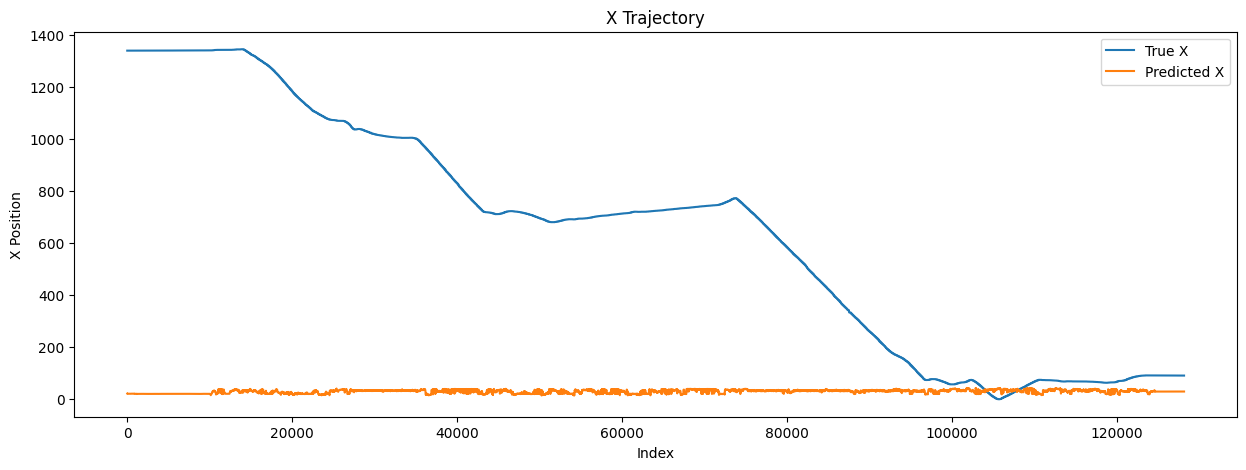

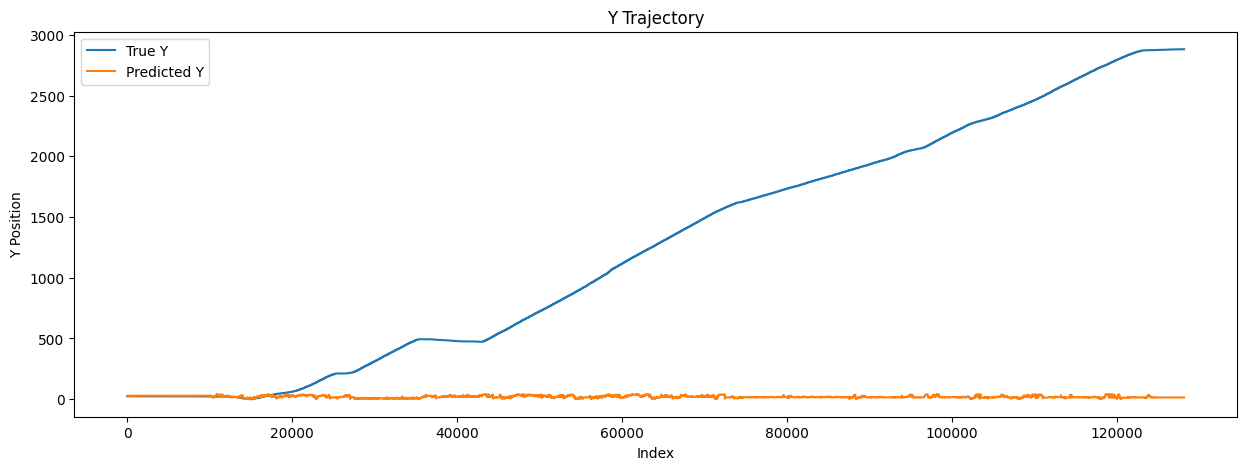

Total Length of Ground Truth Trajectory: 3855.3876427561217
RMSE of the prediction: 1749.282553494667
RMSE of the filtered and scaled and shifted prediction: 940.1759150211607
Scaling factors: [156.25021987 318.71293962]
Shift values: [-4176.9280017  -4857.54540501]
Lags: X=-48792, Y=40934
Processed results saved to own/processed_results/trajectory_model9-6_processed.csv
Total Length of Ground Truth Trajectory single round: 3631.864766731105
RMSE of the prediction single: 940.1759150211607
Weighted RMSE (Corner Accuracy Metric): 940.1759150211607
Drifting Error: 3003.1399991129374


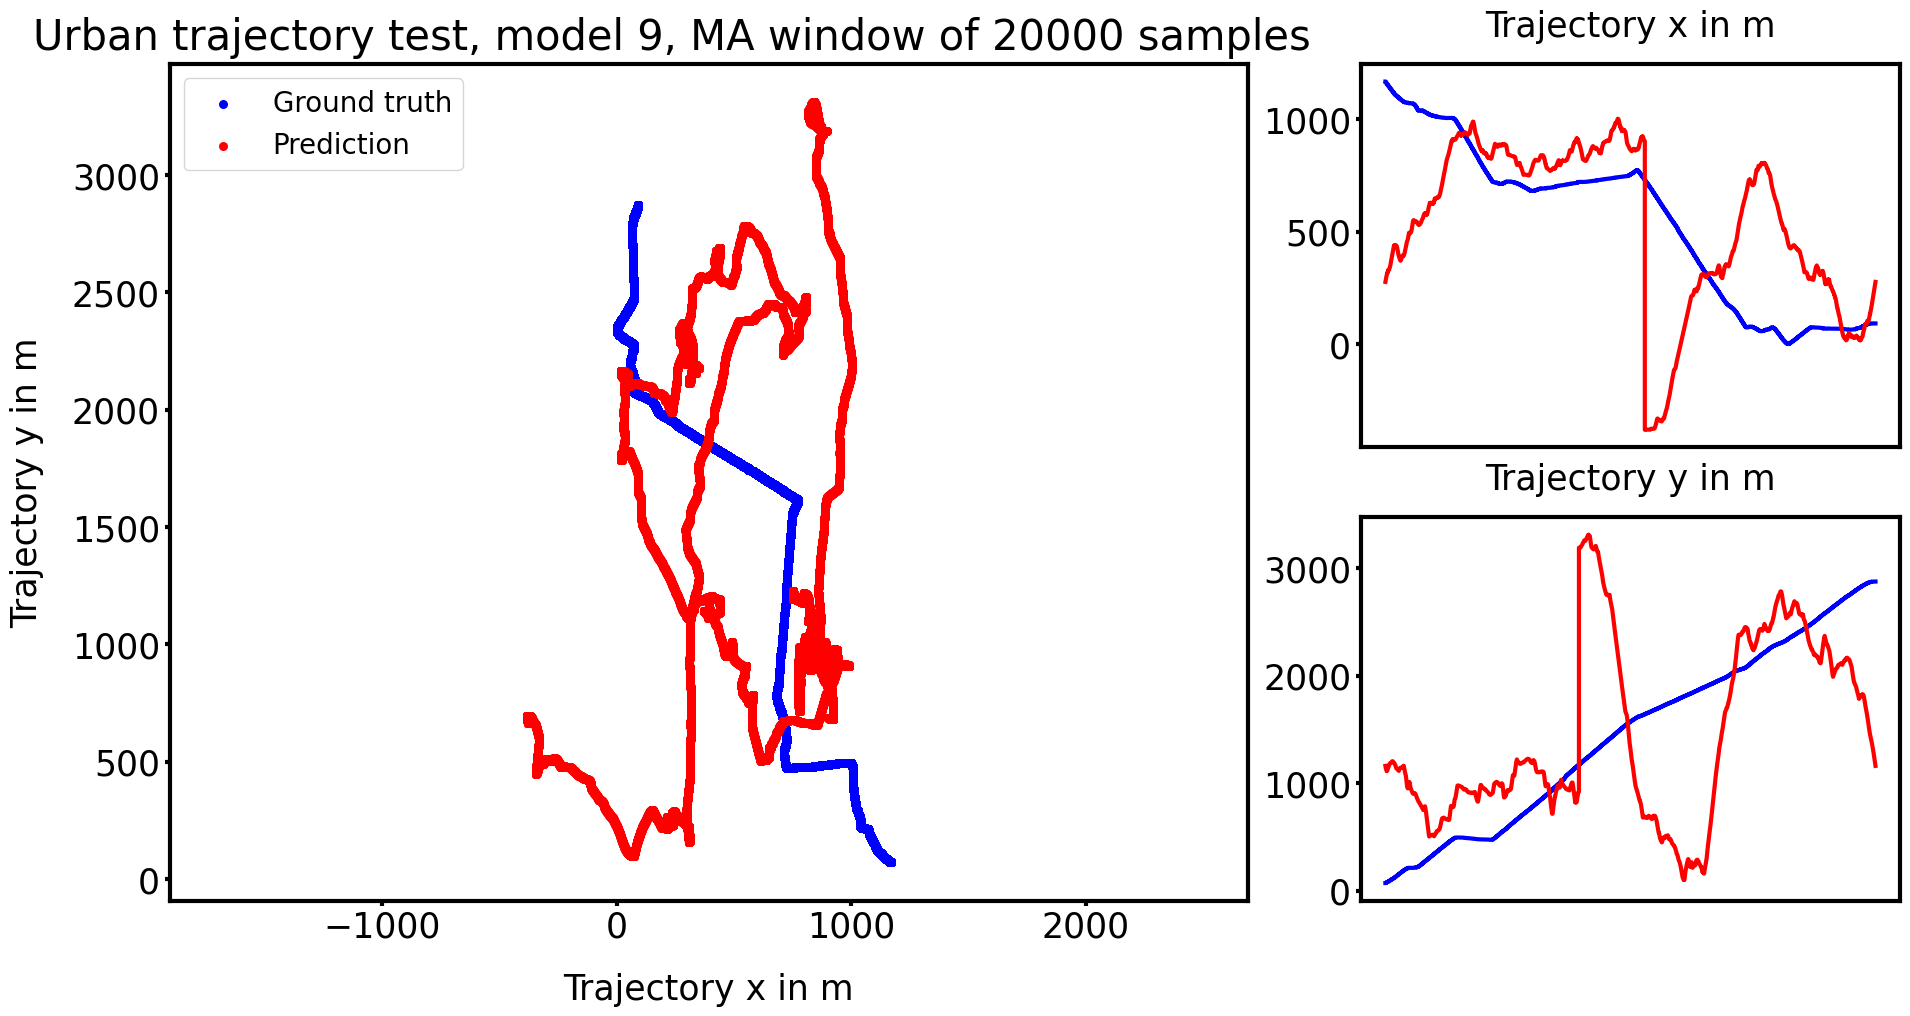

In [8]:
# Load the results
file_path = 'trajectory_predictions9-6.csv'  # Change this to the desired file path

results_df = load_results(file_path)
plot_raw_data(results_df)
total_length = calculate_trajectory_length(results_df)
rmse = calculate_rmse(results_df)
print("Total Length of Ground Truth Trajectory:", total_length)
print("RMSE of the prediction:", rmse)

# Determine the test type based on the file name
test_type = '6-test'  # Adjust accordingly for '6-test' or '7-test'

# Process the data
processed_df, scaling_factors, shift, lags = process_data(results_df, test_type)

# Print the used scaling factors, shift values, and lag values
print(f'Scaling factors: {scaling_factors}')
print(f'Shift values: {shift}')
print(f'Lags: X={lags[0]}, Y={lags[1]}')

# Save the processed data
model_name = 'trajectory_model9-6'  # Change this to the correct model name
save_processed_data(processed_df, model_name)

# Plot the processed data
plot_processed_data_report(processed_df, model_name)